In [1]:
%%capture capt
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.utils import get_laplacian

import sys
sys.path.append('../model')
from mewisPool_layer import MLP, MEWISPool

In [3]:
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

# Define Models

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, device):
        super(Net, self).__init__()

        self.gc1 = GINConv(MLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.pool1 = MEWISPool(hidden_dim=hidden_dim, device=device)
        
        self.gc2 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.pool2 = MEWISPool(hidden_dim=hidden_dim, device=device)
        
        self.gc3 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.gc1(x, edge_index))

        x_pooled, edge_index_pooled, batch_pooled, loss1 = self.pool1(x, edge_index, batch)

        x_pooled = F.relu(self.gc2(x_pooled, edge_index_pooled))

        x_pooled, edge_index_pooled, batch_pooled, loss2 = self.pool2(x_pooled, edge_index_pooled,
                                                                                batch_pooled)

        x_pooled = self.gc3(x_pooled, edge_index_pooled)
        # readout = global_mean_pool(x_pooled, batch_pooled)
        readout = torch.cat([x_pooled[batch_pooled == i].mean(0).unsqueeze(0) for i in torch.unique(batch_pooled)],
                    dim=0)

        out = self.fc1(readout)
        out = torch.relu(out)
        out = self.fc2(out)

        return out, loss1 + loss2

In [5]:
class Net_complex(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, device):
        super(Net_complex, self).__init__()

        self.gc1 = GINConv(MLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.gc2 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.pool1 = MEWISPool(hidden_dim=hidden_dim, device=device)
        
        self.gc3 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.gc4 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        self.pool2 = MEWISPool(hidden_dim=hidden_dim, device=device)
        
        self.gc5 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim, enhance=True))
        
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=num_classes)

    def forward(self, x, edge_index, batch):
        x = self.gc1(x, edge_index)
        x = torch.relu(x)

        x = self.gc2(x, edge_index)
        x = torch.relu(x)

        x_pooled1, edge_index_pooled1, batch_pooled1, loss1 = self.pool1(x, edge_index, batch)

        x_pooled1 = self.gc3(x_pooled1, edge_index_pooled1)
        x_pooled1 = torch.relu(x_pooled1)

        x_pooled1 = self.gc4(x_pooled1, edge_index_pooled1)
        x_pooled1 = torch.relu(x_pooled1)

        x_pooled2, edge_index_pooled2, batch_pooled2, loss2 = self.pool2(x_pooled1, edge_index_pooled1,
                                                                                 batch_pooled1)

        x_pooled2 = self.gc5(x_pooled2, edge_index_pooled2)
        x_pooled2 = torch.relu(x_pooled2)

        readout = torch.cat([x_pooled2[batch_pooled2 == i].mean(0).unsqueeze(0) for i in torch.unique(batch_pooled2)],
                            dim=0)

        out = self.fc1(readout)
        out = torch.relu(out)
        out = self.fc2(out)

        return out, loss1 + loss2

# Apply on MUTAG

### Load data

In [6]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

In [7]:
path = 'data'
dataset = TUDataset(path, name='MUTAG', use_node_attr=True, use_edge_attr=True).shuffle()

input_dim = dataset.num_features
num_classes = dataset.num_classes

In [8]:
def get_dataloaders(BATCH_SIZE=20, VAL_PCT=0.1, TEST_PCT=0.1):
    BATCH_SIZE = 20
    VAL_PCT = 0.1
    TEST_PCT = 0.1
    
    n_train = int(len(dataset) * (1 - VAL_PCT - TEST_PCT))
    n_val = int(len(dataset) * VAL_PCT)
    
    train_dataset = dataset[:n_train]
    val_dataset = dataset[n_train: n_train+n_val]
    test_dataset = dataset[n_train+n_val:]
    
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    return train_loader, val_loader, test_loader

In [9]:
BATCH_SIZE = 20
VAL_PCT = 0.15
TEST_PCT = 0.1

torch.manual_seed(42)
np.random.seed(42)

train_loader, val_loader, test_loader = get_dataloaders(BATCH_SIZE=BATCH_SIZE, VAL_PCT=VAL_PCT, TEST_PCT=TEST_PCT)
print(f'{len(train_loader.dataset)} training samples, {len(val_loader.dataset)} validation samples, '
      f'{len(test_loader.dataset)} test samples.')

150 training samples, 18 validation samples, 20 test samples.


In [10]:
device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


### Load model architectures

In [11]:
hidden_dim = 32
nb_epochs = 200
learning_rate = 1e-4
weight_decay = 1e-5
scheduler_patience = 10
scheduler_factor = 1e-1
patience = 50

In [12]:
def create_model(model_architecture, input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, device=device, 
        learning_rate=learning_rate, weight_decay=weight_decay, scheduler_patience=scheduler_patience, scheduler_factor=scheduler_factor, verbose_scheduler=True):

    model = model_architecture(input_dim=input_dim, 
                hidden_dim=hidden_dim, num_classes=num_classes, device=device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                           patience=scheduler_patience,
                                                           factor=scheduler_factor,
                                                           verbose=verbose_scheduler)
    criterion = torch.nn.CrossEntropyLoss()
    return model, optimizer, scheduler, criterion

### Train models

In [13]:
def validate(model, val_loader, criterion, device):
    val_loss = 0.
    val_corrects = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            data = data.to(device)
            out, loss_pool = model(data.x, data.edge_index, data.batch)
            loss_classification = criterion(out, data.y)
            loss = loss_classification + 0.01 * loss_pool
            val_loss += loss.item()
            val_corrects += (F.softmax(out, dim=1).argmax(dim=1) == data.y).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_corrects / len(val_loader.dataset)
    return val_loss, val_acc

In [14]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    train_loss = 0.
    train_corrects = 0
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out, loss_pool = model(data.x, data.edge_index, data.batch)
        loss_classification = criterion(out, data.y)
        loss = loss_classification + 0.01 * loss_pool

        loss.backward()
        train_loss += loss.item()
        train_corrects += (F.softmax(out, dim=1).argmax(dim=1) == data.y).sum().item()
        optimizer.step()

    train_loss /= len(train_loader)
    train_acc = train_corrects / len(train_loader.dataset)
    scheduler.step(train_loss)
    return train_loss, train_acc

In [15]:
def train(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, nb_epochs, patience, device,
         print_every=None):

    best_val_loss = float('inf')
    best_test_acc = None
    counter = 0

    train_losses,  val_losses, test_losses = [], [], []
    train_accs, val_accs, test_accs = [], [], []

    if print_every is None:
        print_every = 1 if nb_epochs <= 20 else int(nb_epochs/20)

    for epoch in range(nb_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        if epoch % print_every == 0 or epoch == nb_epochs - 1:
            print(f"Epoch [{epoch}/{nb_epochs}], Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Test loss: {test_loss:.3f},"
                  f" Train acc: {train_acc:.2f}, Val acc: {val_acc:.2f}, Test acc: {test_acc:.2f}")

        # Early-Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_test_acc = test_acc
            counter = 0
        else:
            counter += 1

        # Early stopping
        if counter > patience:
            print(f'======== Early stopping at Epoch {epoch} ========')
            if epoch % print_every != 0:
                    print(f"Epoch [{epoch}/{nb_epochs}], Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Test loss: {test_loss:.3f},"
                          f" Train acc: {train_acc:.2f}, Val acc: {val_acc:.2f}, Test acc: {test_acc:.2f}")
            break

    return train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_test_acc

In [16]:
model, optimizer, scheduler, criterion = create_model(Net)
model_5, optimizer_5, scheduler_5, criterion_5 = create_model(Net_complex)

/opt/mamba/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [17]:
train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, _ = train(
    model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, 
    nb_epochs, patience, device, print_every=1)

Epoch [0/200], Train loss: 3.983, Val loss: 4.619, Test loss: 4.516, Train acc: 0.55, Val acc: 0.78, Test acc: 0.60
Epoch [1/200], Train loss: 3.867, Val loss: 4.501, Test loss: 4.430, Train acc: 0.65, Val acc: 0.78, Test acc: 0.60
Epoch [2/200], Train loss: 3.766, Val loss: 4.341, Test loss: 4.311, Train acc: 0.59, Val acc: 0.78, Test acc: 0.60
Epoch [3/200], Train loss: 3.648, Val loss: 4.177, Test loss: 4.136, Train acc: 0.64, Val acc: 0.67, Test acc: 0.55
Epoch [4/200], Train loss: 3.526, Val loss: 3.971, Test loss: 3.941, Train acc: 0.65, Val acc: 0.61, Test acc: 0.50
Epoch [5/200], Train loss: 3.381, Val loss: 3.751, Test loss: 3.763, Train acc: 0.67, Val acc: 0.78, Test acc: 0.55
Epoch [6/200], Train loss: 3.235, Val loss: 3.519, Test loss: 3.556, Train acc: 0.65, Val acc: 0.78, Test acc: 0.60
Epoch [7/200], Train loss: 3.061, Val loss: 3.293, Test loss: 3.327, Train acc: 0.67, Val acc: 0.78, Test acc: 0.60
Epoch [8/200], Train loss: 2.855, Val loss: 3.041, Test loss: 3.090, Tra

In [18]:
train_losses_5, val_losses_5, test_losses_5, train_accs_5, val_accs_5, test_accs_5, _ = train(
    model_5, criterion_5, optimizer_5, scheduler_5, train_loader, val_loader, test_loader, 
    nb_epochs, patience, device, print_every=1)

Epoch [0/200], Train loss: 3.583, Val loss: 4.195, Test loss: 4.112, Train acc: 0.60, Val acc: 0.78, Test acc: 0.60
Epoch [1/200], Train loss: 3.523, Val loss: 4.115, Test loss: 4.071, Train acc: 0.62, Val acc: 0.78, Test acc: 0.60
Epoch [2/200], Train loss: 3.425, Val loss: 4.060, Test loss: 4.009, Train acc: 0.62, Val acc: 0.78, Test acc: 0.60
Epoch [3/200], Train loss: 3.358, Val loss: 3.915, Test loss: 3.947, Train acc: 0.63, Val acc: 0.78, Test acc: 0.60
Epoch [4/200], Train loss: 3.308, Val loss: 3.718, Test loss: 3.786, Train acc: 0.65, Val acc: 0.78, Test acc: 0.60
Epoch [5/200], Train loss: 3.232, Val loss: 3.583, Test loss: 3.620, Train acc: 0.66, Val acc: 0.78, Test acc: 0.60
Epoch [6/200], Train loss: 3.148, Val loss: 3.412, Test loss: 3.464, Train acc: 0.62, Val acc: 0.78, Test acc: 0.60
Epoch [7/200], Train loss: 3.075, Val loss: 3.277, Test loss: 3.345, Train acc: 0.65, Val acc: 0.78, Test acc: 0.60
Epoch [8/200], Train loss: 2.949, Val loss: 3.152, Test loss: 3.214, Tra

### Plot metrics

In [19]:
def plot_metrics(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, suptitle=''): 
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].plot(test_losses, label='Test Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()
    axs[0].grid('on')
    
    # Plot accuracies
    axs[1].plot(train_accs, label='Train Acc')
    axs[1].plot(val_accs, label='Val Acc')
    axs[1].plot(test_accs, label='Test Acc')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    axs[1].grid('on')
    
    plt.tight_layout()
    plt.suptitle(suptitle)
    
    plt.show()

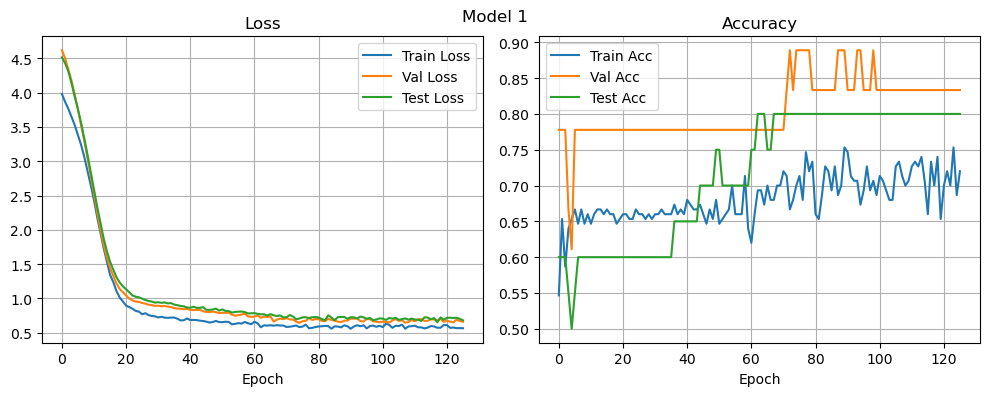

In [20]:
plot_metrics(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, suptitle='Model 1')

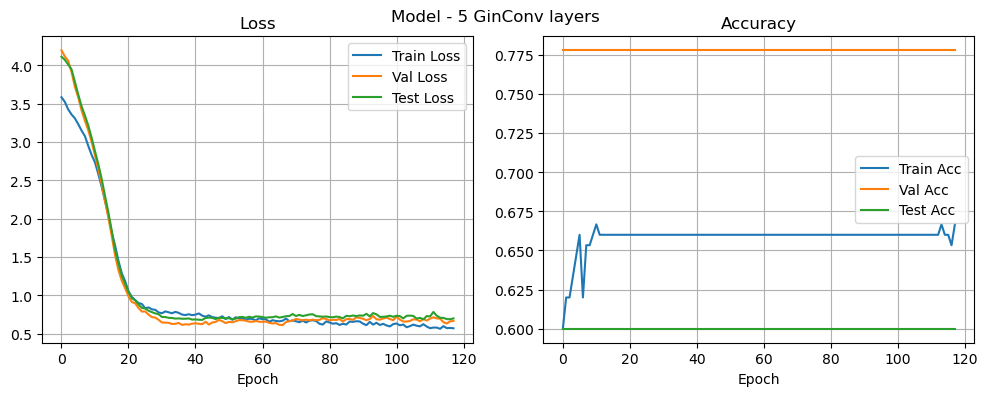

In [21]:
plot_metrics(train_losses_5, val_losses_5, test_losses_5, train_accs_5, val_accs_5, test_accs_5, suptitle='Model - 5 GinConv layers')

### 10-fold validation

In [22]:
def k_fold_loader(dataset, fold, k=10, batch_size=BATCH_SIZE):
    n = len(dataset)//10
    start = n*fold
    end = len(dataset) if fold == k else (fold+1)*n 
    indices = list(range(len(dataset)))
    indices_test = indices[start:end]
    indices_val_train = indices[:start] + indices[end:]
    indices_val = np.random.choice(indices_val_train, size=len(indices_val_train)//10)
    indices_train = [x for x in indices_val_train if x not in indices_val]

    train_dataset = dataset[indices_train]
    val_dataset = dataset[indices_val]
    test_dataset = dataset[indices_test]

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [23]:
BATCH_SIZE = 20
VAL_PCT = 0.15
TEST_PCT = 0.1

hidden_dim = 32
nb_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-5
scheduler_patience = 10
scheduler_factor = 1e-1
patience = 50

In [24]:
def run_all(model_architecture, fold, batch_size=BATCH_SIZE, val_pct=VAL_PCT, test_pct=TEST_PCT, input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, device=device, 
                                learning_rate=learning_rate, weight_decay=weight_decay, scheduler_patience=scheduler_patience, scheduler_factor=scheduler_factor,
                                nb_epochs=nb_epochs, patience=patience):

    train_loader, val_loader, test_loader = k_fold_loader(dataset, fold, k=10, batch_size=BATCH_SIZE)
    model, optimizer, scheduler, criterion = create_model(model_architecture, input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, device=device, 
                                learning_rate=learning_rate, weight_decay=weight_decay, scheduler_patience=scheduler_patience, scheduler_factor=scheduler_factor, verbose_scheduler=False)
    train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_test_acc = train(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, 
                        nb_epochs, patience, device, print_every=nb_epochs)
    return train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_test_acc

In [25]:
def run_10_fold(model_architecture, batch_size=BATCH_SIZE, val_pct=VAL_PCT, test_pct=TEST_PCT, input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, device=device, 
                                learning_rate=learning_rate, weight_decay=weight_decay, scheduler_patience=scheduler_patience, scheduler_factor=scheduler_factor,
                                nb_epochs=nb_epochs, patience=patience, plot_=None):

    results = {}
    index_best_test_acc_all_folds = -1
    best_test_acc_all_folds = 0
    for i in range(10):
        print(f'Running fold {i}')
        train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_test_acc = run_all(model_architecture, i, batch_size=batch_size, val_pct=val_pct, test_pct=test_pct, input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, device=device, 
                                learning_rate=learning_rate, weight_decay=weight_decay, scheduler_patience=scheduler_patience, scheduler_factor=scheduler_factor,
                                nb_epochs=nb_epochs, patience=patience)
        results[i] = train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, best_test_acc
        if best_test_acc_all_folds < best_test_acc:
            best_test_acc_all_folds = best_test_acc
            index_best_test_acc_all_folds = i

    if plot_ is not None:
        train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, _ = results[index_best_test_acc_all_folds]
        plot_metrics(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, suptitle=plot_)
    return results

Running fold 0
Epoch [0/200], Train loss: 3.829, Val loss: 3.345, Test loss: 3.199, Train acc: 0.66, Val acc: 0.71, Test acc: 0.67
======== Early stopping at Epoch 110 ========
Epoch [110/200], Train loss: 0.482, Val loss: 0.567, Test loss: 0.375, Train acc: 0.80, Val acc: 0.76, Test acc: 0.89
Running fold 1
Epoch [0/200], Train loss: 4.054, Val loss: 3.511, Test loss: 3.974, Train acc: 0.43, Val acc: 0.65, Test acc: 0.33
======== Early stopping at Epoch 116 ========
Epoch [116/200], Train loss: 0.364, Val loss: 0.447, Test loss: 0.550, Train acc: 0.84, Val acc: 0.82, Test acc: 0.78
Running fold 2
Epoch [0/200], Train loss: 3.886, Val loss: 3.619, Test loss: 3.519, Train acc: 0.56, Val acc: 0.76, Test acc: 0.56
======== Early stopping at Epoch 66 ========
Epoch [66/200], Train loss: 0.433, Val loss: 0.513, Test loss: 0.447, Train acc: 0.80, Val acc: 0.71, Test acc: 0.78
Running fold 3
Epoch [0/200], Train loss: 3.244, Val loss: 2.872, Test loss: 2.937, Train acc: 0.56, Val acc: 0.71, T

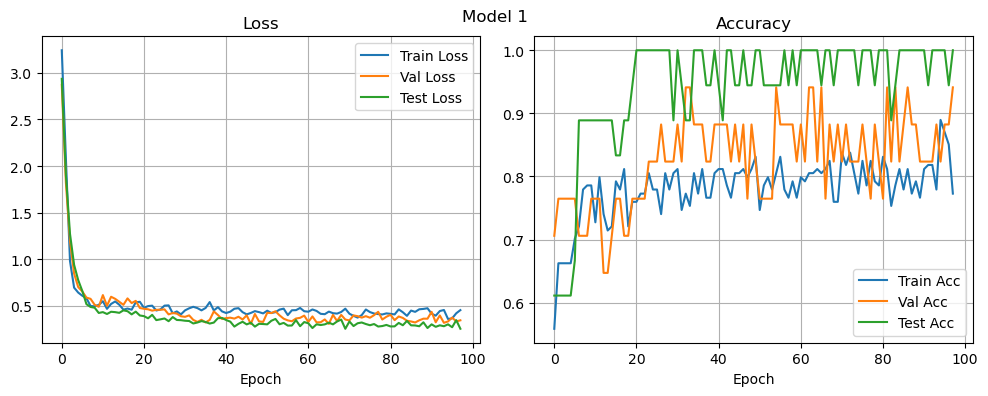

In [26]:
results = run_10_fold(Net, plot_='Model 1')

Running fold 0
Epoch [0/200], Train loss: 3.862, Val loss: 3.237, Test loss: 3.277, Train acc: 0.64, Val acc: 0.88, Test acc: 0.67
======== Early stopping at Epoch 72 ========
Epoch [72/200], Train loss: 0.443, Val loss: 0.721, Test loss: 0.534, Train acc: 0.80, Val acc: 0.47, Test acc: 0.67
Running fold 1
Epoch [0/200], Train loss: 3.777, Val loss: 3.742, Test loss: 3.884, Train acc: 0.66, Val acc: 0.71, Test acc: 0.67
======== Early stopping at Epoch 69 ========
Epoch [69/200], Train loss: 0.412, Val loss: 0.646, Test loss: 0.645, Train acc: 0.84, Val acc: 0.59, Test acc: 0.67
Running fold 2
Epoch [0/200], Train loss: 4.169, Val loss: 3.962, Test loss: 3.512, Train acc: 0.66, Val acc: 0.76, Test acc: 0.56
======== Early stopping at Epoch 162 ========
Epoch [162/200], Train loss: 0.431, Val loss: 0.591, Test loss: 0.591, Train acc: 0.79, Val acc: 0.76, Test acc: 0.72
Running fold 3
Epoch [0/200], Train loss: 3.997, Val loss: 3.486, Test loss: 3.679, Train acc: 0.34, Val acc: 0.29, Tes

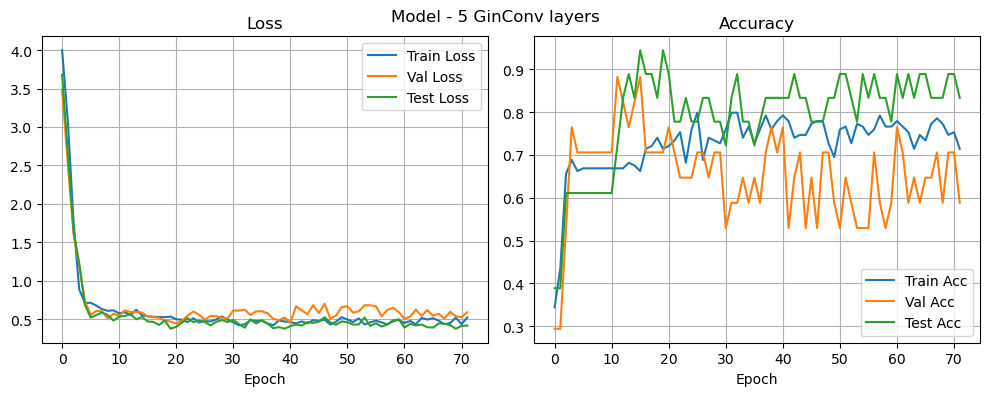

In [27]:
results_5 = run_10_fold(Net_complex, plot_='Model - 5 GinConv layers')

In [28]:
test_accuracy_results = np.mean([results[i][5][-1] for i in range(len(results))])
best_test_accuracy_results = np.mean([results[i][6] for i in range(len(results))])

print('Simple model')
print(f'Average accuracy at last epoch: {round(test_accuracy_results*100, 2)}%')
print(f'Average accuracy at best epoch: {round(best_test_accuracy_results*100, 2)}%')

Simple model
Average accuracy at last epoch: 81.67%
Average accuracy at best epoch: 82.22%


In [29]:
test_accuracy_results_5 = np.mean([results_5[i][5][-1] for i in range(len(results_5))])
best_test_accuracy_results_5 = np.mean([results_5[i][6] for i in range(len(results_5))])

print('Complex model')
print(f'Average accuracy at last epoch: {round(test_accuracy_results_5*100, 2)}%')
print(f'Average accuracy at best epoch: {round(best_test_accuracy_results_5*100, 2)}%')

Complex model
Average accuracy at last epoch: 77.22%
Average accuracy at best epoch: 79.44%
